In [ ]:
!pip install Arabic-Stopwords
!pip install arabic-reshaper 
!pip install python-bidi
!pip install livelossplot
!pip install tensorflow-gpu
!pip install torch
!pip install transformers
!pip install sentencepiece

In [2]:
import numpy as np
import time
import pickle
import os
import tensorflow as tf
import keras
import FileHandler as Fh
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
from Utils import Utils as Utl
from Utils.Evaluation import *

In [ ]:
pickle_inp_path = "/content/Weights/bert_inp.pkl"
pickle_mask_path = "/content/Weights/bert_mask.pkl"
pickle_label_path = "/content/Weights/bert_label.pkl"


def tokenizer_decode(bert_tokenizer, tokenized_sequence):
    bert_tokenizer.decode(tokenized_sequence['input_ids'])


def tokenizer_encode(sentences, labels, max_length):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in sentences:
        bert_inp = bert_tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=max_length,
                                              pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])

    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels


def save_model_pkl(input_ids, attention_masks, labels):
    pickle.dump((input_ids), open(pickle_inp_path, 'wb'))
    pickle.dump((attention_masks), open(pickle_mask_path, 'wb'))
    pickle.dump((labels), open(pickle_label_path, 'wb'))

    print('Pickle files saved as ', pickle_inp_path, pickle_mask_path, pickle_label_path)


def load_model_pkl():
    print('Loading the saved pickle files..')
    input_ids = pickle.load(open(pickle_inp_path, 'rb'))
    attention_masks = pickle.load(open(pickle_mask_path, 'rb'))
    labels = pickle.load(open(pickle_label_path, 'rb'))
    print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape, attention_masks.shape,
                                                                               labels.shape))


def build_bert_model(num_classes):
    bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
    print('\nBert Model', bert_model.summary())
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
    bert_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    return bert_model


def fit_bert_model(bert_model, train_inp, train_mask, train_label,
                   val_inp, val_mask, val_label, weights_dir):
    log_dir = 'tb_bert'
    model_save_path = os.path.join(weights_dir, 'bert_model.h5')
    callbacks = [ModelCheckpoint(filepath=model_save_path,
                                 save_weights_only=True,
                                 monitor='val_loss',
                                 mode='min',
                                 verbose=1,
                                 save_best_only=True),
                 EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5),
                 PlotLossesKeras(),
                 keras.callbacks.TensorBoard(log_dir=log_dir)]

    start_time = time.time()
    history = bert_model.fit([train_inp, train_mask], train_label,
                             batch_size=32, epochs=20,
                             validation_data=([val_inp, val_mask], val_label),
                             callbacks=callbacks)
    duration = time.time() - start_time
    print("Model take {} S to train ".format(duration))
    return bert_model, history

In [ ]:
if __name__ == '__main__':
    csv_file_path = "/content/drive/MyDrive/Dataset/DigiSay/preprocessed_df.csv"
    df = Fh.read_arabic_csv(csv_file_path)

    values = {"content": "<NONE>",
              "top_5_word": "<NONE>"}

    df = df.fillna(values)

    train, val = Utl.split_dataset(df, y_col="class", test_size=0.2, with_stratify=True, shuffle=True)
    # train, test = Utl.split_dataset(train, y_col="class", test_size=0.1, with_stratify=True, shuffle=True)

    
    label_encoder = Utl.get_label_encoder_obj(train["class"])
    path_directory = "/content/Weights"
    file_name = "label_encoder.pkl"
    Utl.save_model_pkl(label_encoder, path_directory, file_name)
    file_name = "/content/Weights/label_encoder.pkl"
    label_encoder = Utl.load_model_pkl(file_name)
    train["class"] = Utl.get_y_label_encoder(label_encoder, train["class"])
    val["class"] = Utl.get_y_label_encoder(label_encoder, val["class"])

    #max_statment_len = get_max_statment_len(train, "content")
    max_statment_len = 50

    train_inp, train_mask, train_label = tokenizer_encode(train["content"], train["class"], max_statment_len)
    val_inp, val_mask, val_label = tokenizer_encode(val["content"], val["class"], max_statment_len)

    num_classes = Utl.get_nb_classes(train["class"])

https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpqybakyy4


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmppdh_etmi


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/t

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
creating metadata file for /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "h

In [ ]:
bert_model = build_bert_model(num_classes)
bert_model

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 not found in cache or force_download s

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 in cache at /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5
creating metadata file for /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cache at /root/.cache/huggingface/transformers/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN 

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


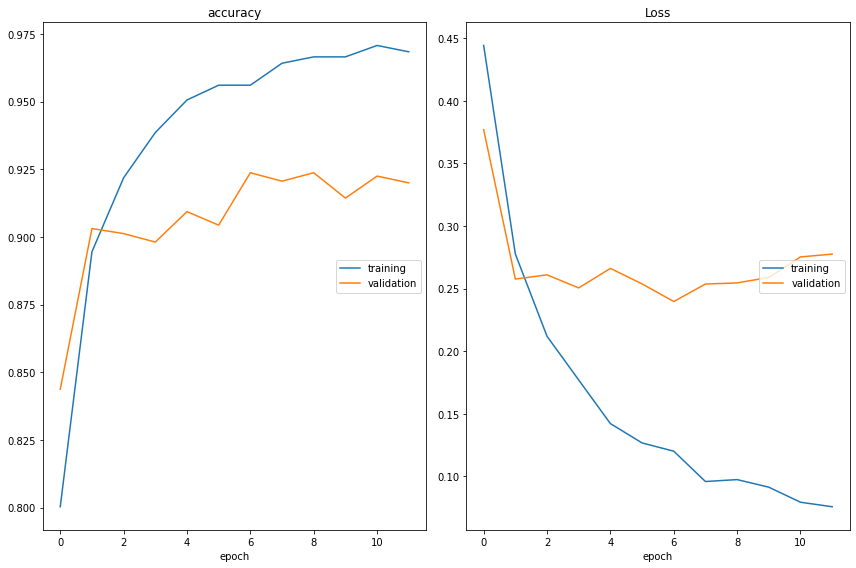

accuracy
	training         	 (min:    0.800, max:    0.971, cur:    0.968)
	validation       	 (min:    0.844, max:    0.924, cur:    0.920)
Loss
	training         	 (min:    0.076, max:    0.444, cur:    0.076)
	validation       	 (min:    0.240, max:    0.377, cur:    0.278)
200/200 [==============================] - 102s 510ms/step - loss: 0.0758 - accuracy: 0.9684 - val_loss: 0.2775 - val_accuracy: 0.9200
Epoch 12: early stopping
Model take 1220.5935561656952 S to train 


In [ ]:
weights_dir = "/content/Weights/"
bert_model, history = fit_bert_model(bert_model, train_inp, train_mask, train_label,
                                              val_inp, val_mask, val_label, weights_dir)

In [ ]:
bert_model.load_weights("/content/Weights/bert_model.h5")
y_hat = bert_model.predict([val_inp, val_mask])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
from tensorflow.nn import softmax 

y_hat = softmax(y_hat.logits, axis=-1)
y_hat = np.argmax(y_hat, axis=-1)

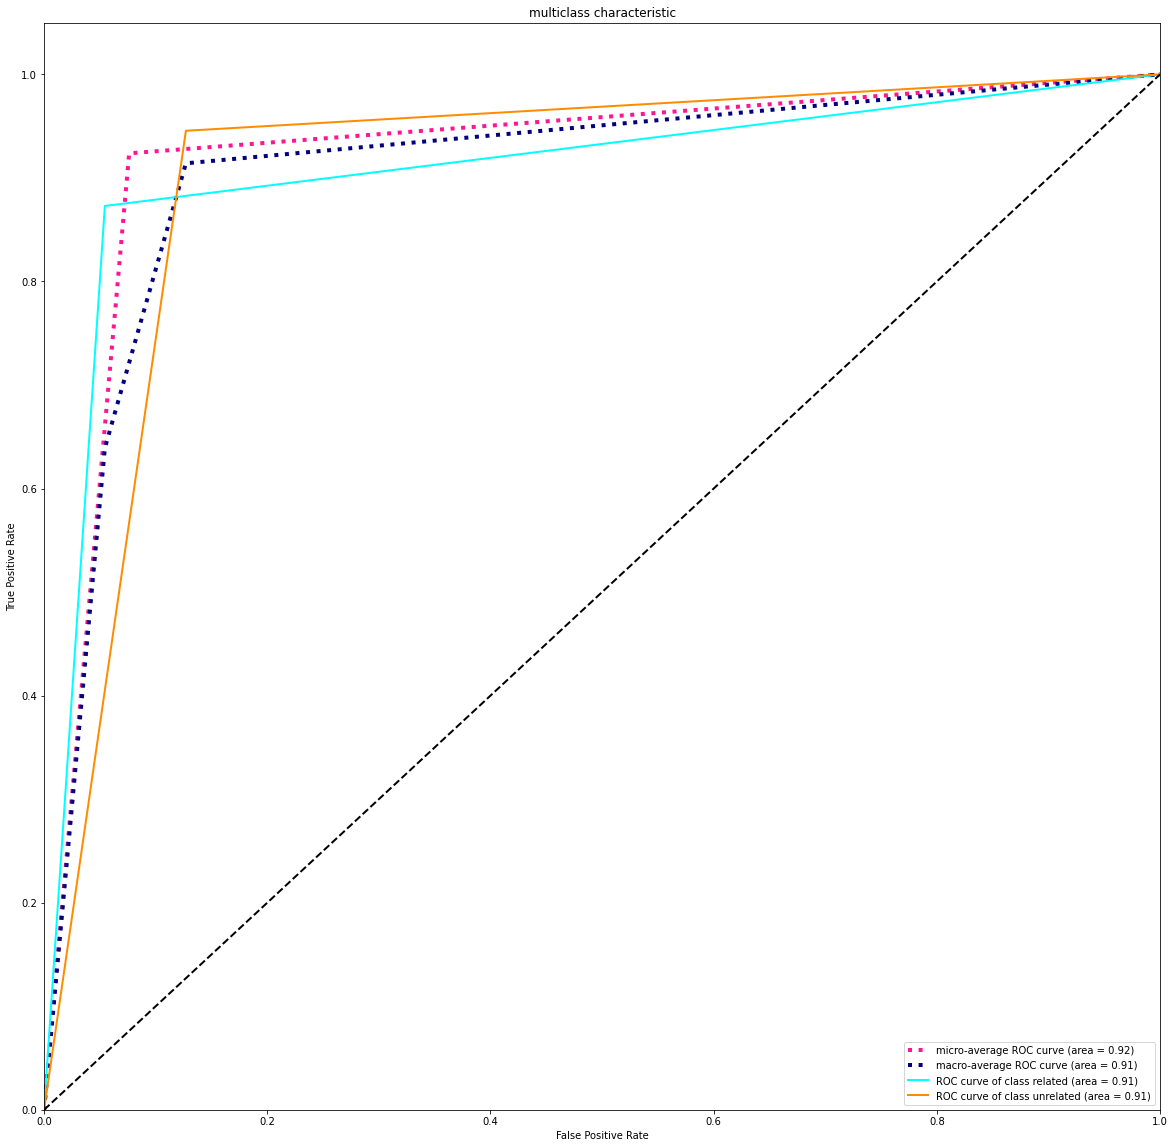

Accuracy:  0.92375
Precision::  0.92375
Recall::  0.92375
F1_Score::  0.92375

Macro precision_recall_fscore_support (macro) average
(0.9092261904761905, 0.9092261904761905, 0.9092261904761905, None)

Macro precision_recall_fscore_support (micro) average
(0.92375, 0.92375, 0.92375, None)

Macro precision_recall_fscore_support (weighted) average
(0.92375, 0.92375, 0.92375, None)

Confusion Matrix


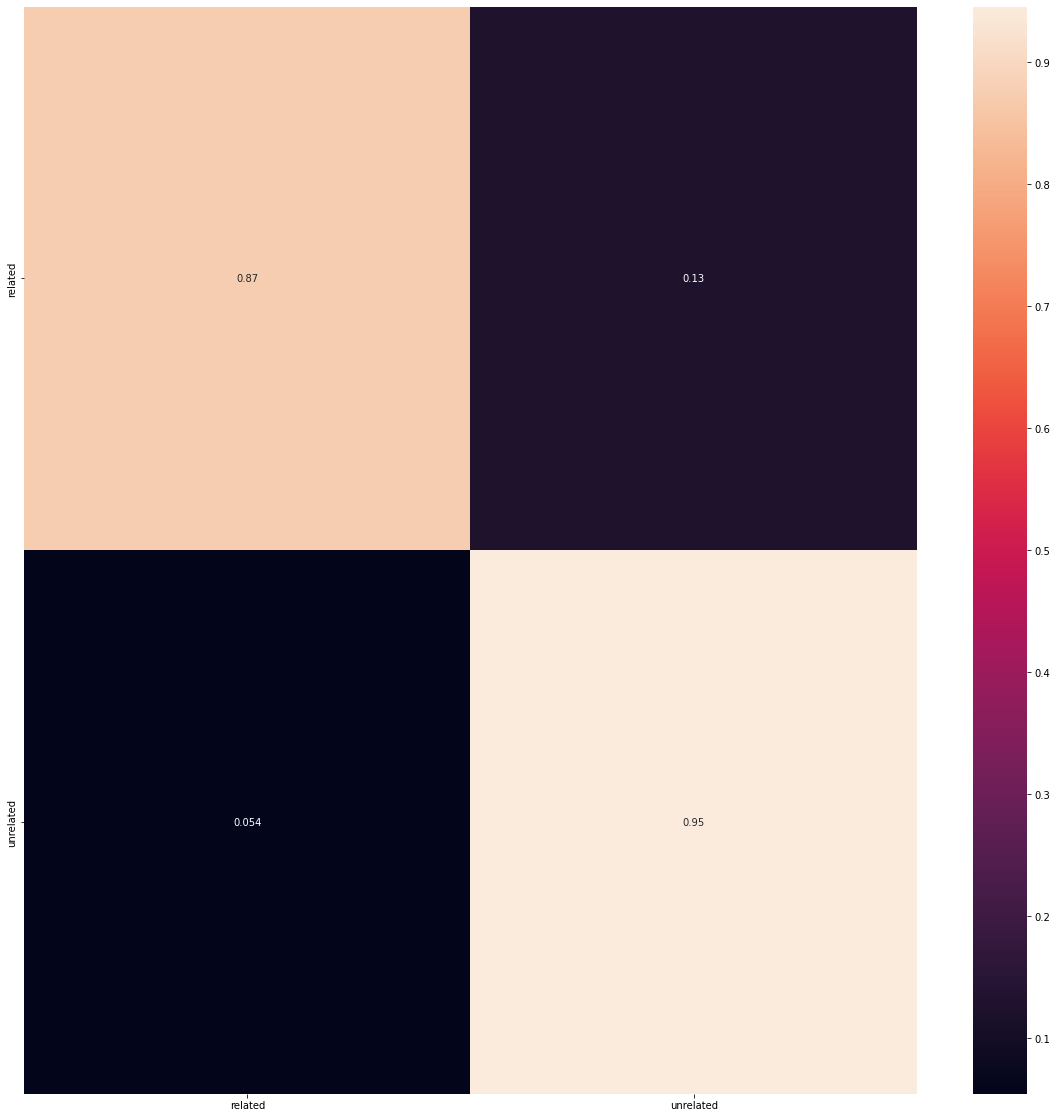


Classification Report
              precision    recall  f1-score   support

     related       0.87      0.87      0.87       480
   unrelated       0.95      0.95      0.95      1120

    accuracy                           0.92      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.92      0.92      0.92      1600



In [ ]:
Utl.get_prediction_results(val_label, y_hat, label_encoder, num_classes)